In [1]:
#data
import numpy as np
import pandas as pd
import pdfplumber
import xarray as xr
from pathlib import Path
from typing import Dict, Any


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set_style("whitegrid")

#Bayes
import pymc as pm
import arviz as az
import pytensor.tensor as pt

#Make sure it can see the system path
from pathlib import Path
import sys

# Add parent directory of the notebook (the project root) to sys.path
ROOT = Path().resolve().parent   # X/
sys.path.insert(0, str(ROOT))

#Other modules
from utils import data_utils
from bayes import DATA_DIR


In [2]:
pm.__version__

'5.8.2'

In [4]:
coords=data_utils.get_coords()

# Load the evidence

In [5]:
process_evidence=data_utils.load_process_evidence(kind="2xCO2")
emergent_contraint_evidence=data_utils.load_emergent_constraint_evidence()
cmip_evidence=data_utils.load_CMIP_land_data(kind="2xCO2")

evidence = process_evidence | emergent_contraint_evidence | cmip_evidence

# Set the priors

Here, I'm defining priors (as opposed to hyperpriors) to be our initial informed guesses about the parameters that map onto real-world physical processes.  I've split these up into priors on the full land CO$_2$ response $\beta_L$ and on the tropical ($\gamma_{LT}$) and extratropical $\gamma_{LX}$ climate responses:

In [6]:
beta_gamma_priors={"βL":lambda name: pm.Uniform(name,0,10),\
       "γLX": lambda name: pm.Normal(name,-100,100),\
       "γLT": lambda name: pm.Normal(name,-100,100)}

And priors on the scaling factors:

In [7]:
# process priors

beta_scaling_priors={"η_nitrogen": lambda name: pm.Uniform(name,0.001,1),\
            "η_fire": lambda name: pm.Uniform(name,0.001,2),\
            "δβ_permafrost": lambda name: pm.Normal(name,1.0,.00001),\
            "η_vegetation": lambda name: pm.Uniform(name,0.001,2)}

gamma_scaling_priors={"ν_nitrogen": lambda name: pm.Uniform(name,0.001,1),\
            "ν_fire": lambda name: pm.Uniform(name,0.001,2),\
            "δγ_permafrost": lambda name: pm.Normal(name,-100.0,100),\
            "ν_vegetation": lambda name: pm.Uniform(name,0.001,2)}

proc_priors=beta_scaling_priors | gamma_scaling_priors

priors = beta_gamma_priors | proc_priors

# Set the hyperpriors (Or use defaults)
You can think of these as nuisances: they apply to parameters in the forward models we use to make sense of our evidence.   I've split these up into hyperpriors on the process evidence, hyperpriors on the emergent constraint parameters, and hyperpriors on the CMIP6 covariance matrix.

In [8]:
#Assume model spread in scaling is the same for every process
#This is the PRECISION: 1/sigma (for numerical stability)
#The bigger it is the more representative a single process-based run will be
hyperpriors_process={"τ_eta": lambda name: pm.HalfNormal(name,0.5),\
            "τ_nu": lambda name: pm.HalfNormal(name,0.5)}

# Priors on the slope and y-intercept of the emergent constraint line
hyperpriors_ec = {'m': lambda name: pm.Normal(name,0,10),
        'b': lambda name: pm.Normal(name,0,10)}

# Priors on CMIP model structural spread
hyperpriors_cov = {"chol": lambda name: pm.LKJCholeskyCov(
    name,
    n=len(coords["parameter"]),
    eta=2.0,         # Strength of the LKJ prior; 1 = uniform over correlations
    sd_dist=pm.HalfNormal.dist(100.0)
            )}

hyperpriors = hyperpriors_process | hyperpriors_ec | hyperpriors_cov


# Validate the priors
Make sure we've specified everything we need

In [9]:
data_utils.validate_priors(priors,hyperpriors=hyperpriors)

## STEP 1: Use the single-process runs to estimate the scaling factors
Right now we don't know much about the scaling factors because we don't have very many process runs.  The posteriors on $\nu$ and $\gamma$ for each process are going to depend very strongly on two things: 
* our priors on the scaling factors
* how much model spread in the scaling factors we expect there to be

The former is controlled by our physical intuition, as specified above.  The latter is controlled by the $\tau$ parameter.  If the model spread in the scaling factor is assumed to be small, then even a single process-based run will be very informative about the scaling factor.  If it's big, then a single process-based run tells us almost nothing at all.

The more single-process runs we get, the more we can constrain both the scaling factor and the model spread.


### Mathematical model
We assume that for each process $j$ (where $j$ is one of ["nitrogen","fire","vegetation"]) the single-process evidence from ESM $i$ is 
$$\eta_{j}^i \sim N(\eta_{j},\tau_{\eta}^{-1})$$
and 
$$\nu_{j}^i \sim N(\nu_{j},\tau_{\nu}^{-1})$$
where $\eta_j$ and $\nu_j$ are the true real-world values of the scaling factors associated with process $j$.

### Caveats

* Right now I assume no cross-correlations between $\eta$ and $\nu$. It might be reasonable (if more complicated) to assume a model with large $\eta_{N}$ (or whatever) also has large $\gamma_N$.
* I assume a single $\tau_{\nu}$ or $\tau_{\beta}$ for every process.

In [10]:
def make_process_model(model,evidence,priors,hyperpriors):


    with model:
        for k,values in coords.items():
            if k not in model.coords:
                model.add_coord(k,values)
        etalist=[]
        for process in coords["process"]:
            etalist+=[priors[f"η_{process}"](name=f"η_{process}")]
        eta = pm.Deterministic("η",pm.math.stack(etalist),dims=("process",))


        #Assume model spread is the same for every process
        #This is the PRECISION: 1/sigma
        #The bigger it is the more representative a single process-based run will be
       
        tau_eta=hyperpriors["τ_eta"](name="τ_eta")
        tau_nu=hyperpriors["τ_nu"](name="τ_nu")
        #Now update the posteriors for eta_process with the process ensembles
        for k,process in enumerate(coords["process"]):
            pm.Normal("lik_eta_"+process,eta[k],tau=tau_eta,observed=evidence[f"η_{process}"])


        nulist=[]
        for process in coords["process"]:
            nulist+=[priors[f"ν_{process}"](name=f"ν_{process}")]
        nu = pm.Deterministic("ν",pm.math.stack(nulist),dims=("process",))

    # Assume common spread tau_process
    #Now update the posteriors for eta_process with the process ensembles
        for k,process in enumerate(coords["process"]):
            pm.Normal("lik_nu_"+process,nu[k],tau=tau_nu,observed=evidence[f"ν_{process}"])    
    return {"ν":nu,"η":eta, "τ_eta":tau_eta,"τ_nu":tau_nu}

In [11]:
with pm.Model() as test_process_model:
    params=make_process_model(test_process_model,evidence,priors,hyperpriors)
    test_process_trace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'ν_nitrogen'}>,
       <Axes: title={'center': 'ν_fire'}>,
       <Axes: title={'center': 'ν_vegetation'}>], dtype=object)

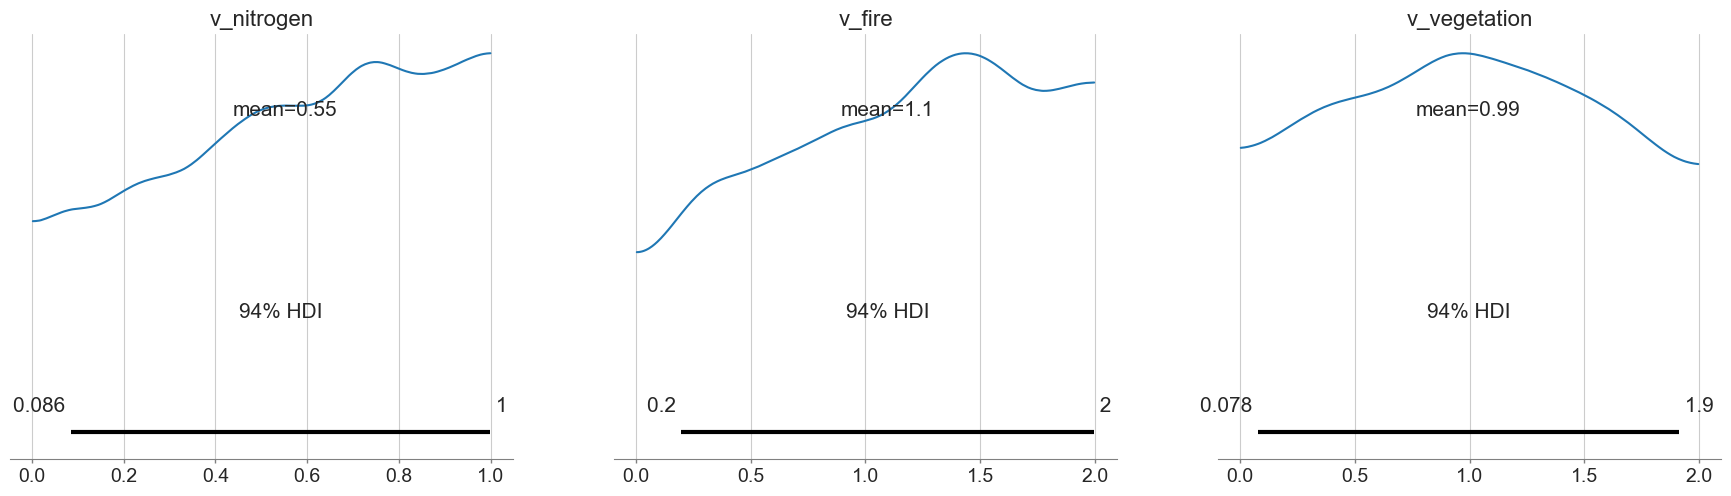

In [24]:
az.plot_posterior(test_process_trace,var_names=[f"ν_{proc}" for proc in coords["process"]])

## STEP 2: Emergent constraint model

In CMIP6, the (uncertain) tropical climate effect $\gamma_{LT}$ appears related to the (uncertain) interannual variability in atmospheric carbon, which is an observable quantity:


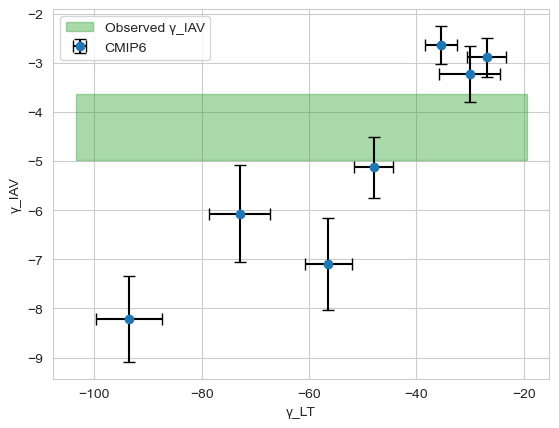

In [25]:
X=evidence['γ_LT']
Y=evidence['γ_IAV']
Xerr=evidence['σ_LT']
Yerr=evidence['σ_IAV']
plt.errorbar(
    X, Y,
    xerr=Xerr,
    yerr=Yerr,
    fmt='o',            # marker style
    ecolor='black',      # error bar color
    capsize=4,           # size of the caps
    linestyle='none',    # no line connecting points
    label='CMIP6'     # label
)
plt.xlabel('γ_LT')
plt.ylabel('γ_IAV')

lower=evidence["IAV_observed_mean"]- evidence["IAV_observed_std"]
upper=evidence["IAV_observed_mean"]+ evidence["IAV_observed_std"]
xax=np.linspace(*plt.xlim(),10)
plt.fill_between(xax,np.zeros_like(xax)+lower,np.zeros_like(xax)+upper,color=cm.tab10(2),alpha=.4,\
                label="Observed γ_IAV")
plt.legend()

In [14]:
def make_emergent_constraint_model(model,evidence,priors,hyperpriors):
    with model:
        ### EMERGENT CONSTRAINT ###
        # EMERGENT CONSTRAINT ON TROPICAL γLT
        n_models_EC=len(evidence['γ_LT'])
        γLT=priors["γLT"](name="γLT")
            #Assume linear relationships
        # Hyperpriors on slope and intercept
        m = hyperpriors["m"](name="m")
        b = hyperpriors["b"](name="b")

        # Errors-in-variables model for model gammaLT- use standard deviations reported by Zechlau
        x_true = pm.Normal("γLT_CMIP", mu=evidence['γ_LT'], \
                           sigma=evidence['σ_LT'], \
                           shape=n_models_EC)

        # Linear model for "true IAV" values
        y_true = m * x_true + b

        # Likelihood of observed IAV values
        y_likelihood = pm.Normal("IAV_CMIP", mu=y_true, \
                                 sigma=evidence['σ_IAV'],\
                                 shape=n_models_EC,\
                                 observed=evidence['γ_IAV'])
        #Emergent constraint relationship

        mu_obs = m * γLT + b
        # IAV observed ~ N(-4.3,0.67) #CHECK IF THIS IS ONE OR TWO SIGMA
        IAV_true=pm.Normal("IAV_true",mu=mu_obs,\
                           sigma=evidence["IAV_observed_std"],\
                           observed = [evidence["IAV_observed_mean"]])
        return {"γLT":γLT}

In [15]:
with pm.Model() as ec_test_model:
    test=make_emergent_constraint_model(ec_test_model,emergent_contraint_evidence,priors,hyperpriors)
    ec_test_trace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γLT, m, b, γLT_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


<Axes: title={'center': 'γLT'}>

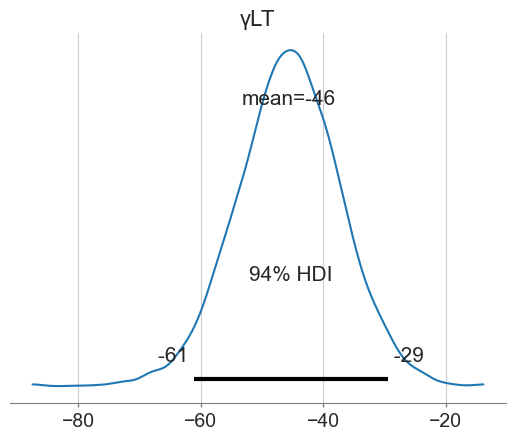

In [26]:
az.plot_posterior(ec_test_trace.posterior.γLT)

In [17]:
#D must have dimensions (Nmodels,2)

D=np.stack([evidence["βL_cmip"],evidence["γL_cmip"]]).T


#def covariance_model(model):
with pm.Model() as bigmodel:

    ########
    #get eta, nu, tau_eta, tau_nu from the process model
    #######
    process_model=make_process_model(bigmodel,
                                     evidence,
                                     priors,
                                     hyperpriors)
    eta=process_model["η"]
    nu=process_model["ν"]
    tau_eta=process_model["τ_eta"]
    tau_nu=process_model["τ_nu"]
    
    ## Add the CMIP data in the form of mutable data
    CMIP = pm.MutableData("CMIP",D)
    
    
    
    for k,values in coords.items():
            if k not in bigmodel.coords:
                bigmodel.add_coord(k,values)
        
    # Prior on gamma_extratropics
    gamma_extratropics=priors["γLX"](name="γLX")
    # Get gamma tropics from the emergent constraint model
    emergent_constraint_model=make_emergent_constraint_model(bigmodel,\
                                                             evidence,\
                                                             priors,\
                                                             hyperpriors)
    gamma_tropics=emergent_constraint_model["γLT"]
    
    # The total gamma is the sum of extratropics and tropics
    gamma = pm.Deterministic("γL",gamma_extratropics+gamma_tropics)
    # and the prior on beta
    beta=priors["βL"](name="βL")
    mu=pm.Deterministic("μ",pm.math.stack([beta,gamma]),dims=("parameter",))
    
    # Prior on Cholesky decomposition of covariance matrix (has to be LKJ)
    # sd_dist gives priors for standard deviations
    #Make these really wide if you like- reflects model structural spread
    chol, corr, sigma = hyperpriors["chol"](name="chol")

    
    # Construct covariance matrix from Cholesky
    Sigma = pm.Deterministic("Sigma", chol.dot(chol.T),dims=("parameter","cross_parameter"))
   
    #get eta for each model
     
    
    Eta_arr = pt.ones((len(coords["process"]), len(coords["model"])))
    Nu_arr = pt.ones((len(coords["process"]), len(coords["model"])))
    
    for j in range(len(coords["process"])):
        # Use pm.math.switch to multiply by eta[j] only where lookup_table[j, :] == 1
        Eta_arr = pt.set_subtensor(Eta_arr[j, :], 
                                          pm.math.switch(pt.eq(evidence["lookup table"][j, :], 1), eta[j], 1.0))
        Nu_arr = pt.set_subtensor(Nu_arr[j, :], 
                                         pm.math.switch(pt.eq(evidence["lookup table"][j, :], 1), nu[j], 1.0))
    
    # Unscaled B
    
    B = beta / pm.math.prod(eta)
    G = gamma / pm.math.prod(nu)
 
    
    # Do mu
    mu_model=[]
    for i,model in enumerate(coords["model"]):
       
        eta_model=pm.math.prod(Eta_arr[:,i])
        nu_model=pm.math.prod(Nu_arr[:,i])
        mu_model+=[pm.math.stack([eta_model*B,nu_model*G])]
    mu_totals = pm.Deterministic("all_mus",
                                 pm.math.stack([mu_model[i] for i,model in enumerate(coords["model"])]),
                                              dims=("model",))
    
    pm.MvNormal(f'D', mu=mu_totals, chol=chol, observed=CMIP)
    covtrace=pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation, γLX, γLT, m, b, γLT_CMIP, βL, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.


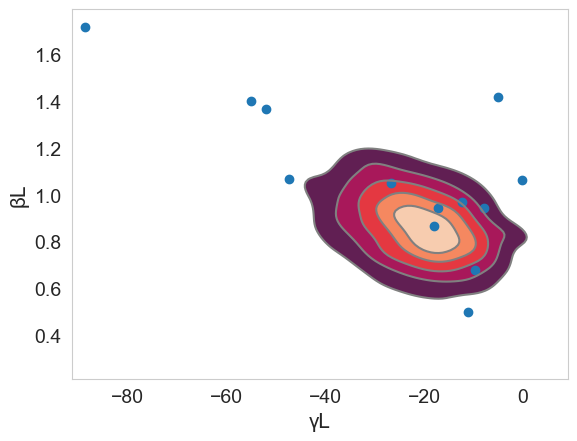

In [30]:
az.plot_pair(covtrace,var_names=["γL","βL"],kind="kde")
plt.scatter(evidence["γL_cmip"],evidence["βL_cmip"])

<Axes: xlabel='γLT', ylabel='γLX'>

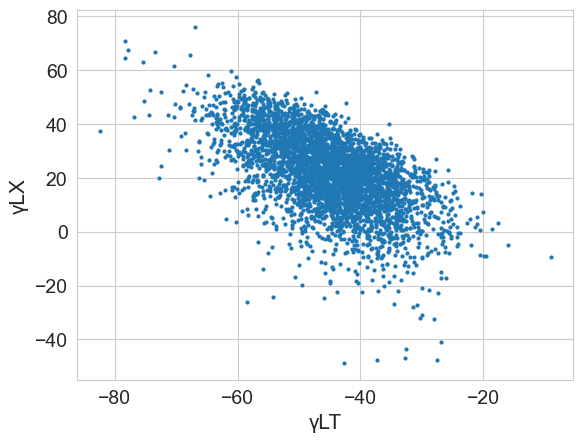

In [19]:
az.plot_pair(covtrace,var_names=["γLT","γLX"])